# NVCL_KIT 3D Plot Demonstration

*Acknowledgment: Borehole dataset courtesy of South Australia Department for Energy and Mining. (https://energymining.sa.gov.au/minerals)*

In [1]:
from nvcl_kit.reader import NVCLReader

In [2]:
from types import SimpleNamespace

In [3]:
param = SimpleNamespace()

Set the URL for the WFS service

In [4]:
param.WFS_URL = "https://sarigdata.pir.sa.gov.au/geoserver/ows"

Set the URL for the NVCL service

In [5]:
param.NVCL_URL = "https://sarigdata.pir.sa.gov.au/nvcl/NVCLDataServices"

Define a narrow area in which to search for boreholes

In [6]:
param.BBOX =  { "west": 134.761, "south": -31.228, "east": 134.767, "north": -31.224 }

Initialise reader object and check for errors

In [7]:
reader = NVCLReader(param)
if not reader.wfs:
        print("ERROR!")

Get borehole information from WFS service

In [8]:
bh_list = reader.get_boreholes_list()

Create a dictionary of coordinates - key is NVCL id, value is (x,y) tuple

In [9]:
nvcl_id_list = [elem['nvcl_id'] for elem in bh_list]
xy_dict = {elem['nvcl_id']:(elem['x'],elem['y']) for elem in bh_list}


A function which fetches the first instance of borehole data

In [10]:


def get_bh_data(nvcl_id):
    # Log name has 2 parts:
    # 1. Min1,2,3 = 1st, 2nd, 3rd most common mineral
    #    OR Grp1,2,3 = 1st, 2nd, 3rd most common group of minerals
    # 2. uTSAV = visible light, uTSAS = shortwave IR, uTSAT = thermal IR
    #
    # These combine to give us a class name such as 'Grp1 uTSAS'
    #
    # Here we extract data for log type '1' and log name 'Grp1 uTSAS'
    imagelog_data_list = reader.get_imagelog_data(nvcl_id)
    for ild in imagelog_data_list[:10]:
        if ild.log_type == '1' and ild.log_name == 'Grp1 uTSAS':
            bh_data = reader.get_borehole_data(ild.log_id, 50, 'Grp1 uTSAS', top_n=8)
            return bh_data
    return None


Assemble list of borehole data

In [11]:
bh_data_list = [get_bh_data(n_id) for n_id in nvcl_id_list]

A routine to make data points for 3D plot, for one kind of mineral class

In [12]:
# A routine to make graded data points for 3D plot, for one kind of mineral class
#
# Parameters:
#  mineral_name (string): name of mineral class
#  bh_data_list (list): list of borehole data
#  offset (integer): small depth offset number used to ensure data points from each mineral class do not overwrite each other
#
# Returns a tuple (X,Y,Z,colours): 
#      X (dict): key = grade (float), value = plot's X value (float)
#      Y (dict): key = grade (float), value = plot's Y value (float)
#      Z (dict): key = grade (float), value = plot's Z (depth) value (float)
#      colours (dict): key = grade (float), value = plot's colour (float,float,float)
#
def make_splatter(mineral_name, bh_data_list, offset):
    X, Y, Z, colours = ({},{},{},{})
    
    # Mineral concentrations (counts) at each depth are sorted into 4 grades
    grades = [0.25, 0.5, 0.75, 1.00]
    for g in grades:
        X[g], Y[g], Z[g], colours[g] = ([], [], [], [])

    # Find the maximum and minimum counts for a specific mineral class 
    max_count = -1
    min_count = 999999
    # Loop over all boreholes
    for n_idx, bh_data in enumerate(bh_data_list):
        if bh_data:
            
            # Loop over depths
            for depth in bh_data:
                
                # Loop over each mineral class at a given depth
                for elem in bh_data[depth]:
                    if elem.classText == mineral_name:
                        # Find max and min count
                        max_count = max(max_count, elem.classCount)
                        min_count = min(min_count, elem.classCount)
            
    # Assemble X,Y,Z values and colours for plot
    
    # Loop over boreholes
    for n_idx, bh_data in enumerate(bh_data_list):
        if bh_data:
            
            # Loop over depths
            for depth in bh_data:
                
                # Loop over each mineral class at a given depth
                for elem in bh_data[depth]:
                    if elem.classText == mineral_name:
                        
                        # For each grade
                        for g in grades:
                            # Find appropriate grade for this mineral class
                            scaled_count = (elem.classCount - min_count)/(max_count - min_count)
                            if scaled_count < g:
                                # Add to list of X,Y,Z & colours
                                X[g].append(xy_dict[nvcl_id_list[n_idx]][0])
                                Y[g].append(xy_dict[nvcl_id_list[n_idx]][1])
                                Z[g].append(depth+offset)
                                colours[g].append(elem.colour)
                                break
    return X, Y, Z, colours   

Create the 3D plot

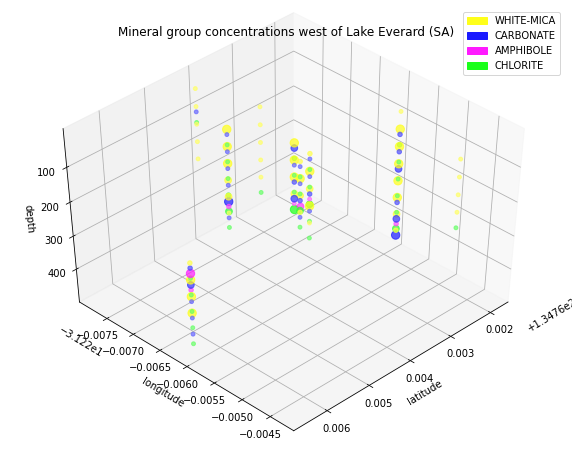

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Fetch X,Y,Z coords and colours for WHITE-MICA
X,Y,Z,colours = make_splatter('WHITE-MICA', bh_data_list, 0)

# Draw the WHITE-MICA colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(1,1, 0.4), s=15, alpha=0.7)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(1,1, 0.3), s=20, alpha=0.7)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(1,1, 0.2), s=45, alpha=0.7)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(1,1,0.1), s=70, alpha=0.7)

# Fetch X,Y,Z coords and colours for CARBONATE
X,Y,Z,colours = make_splatter('CARBONATE', bh_data_list, 15)

# Draw the CARBONATE colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(0.4,0.4,1), s=15, alpha=0.7)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(0.3,0.3,1), s=20, alpha=0.7)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(0.2,0.2,1), s=45, alpha=0.7)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(0.1,0.1,1), s=70, alpha=0.7)

# Fetch X,Y,Z coords and colours for AMPHIBOLE
X,Y,Z,colours = make_splatter('AMPHIBOLE', bh_data_list, 30)

# Draw the AMPHIBOLE colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(1,0.4,1), s=15, alpha=0.7)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(1,0.3,1), s=20, alpha=0.7)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(1,0.2,1), s=45, alpha=0.7)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(1,0.1,1), s=70, alpha=0.7)

# Fetch X,Y,Z coords and colours for CHLORITE
X,Y,Z,colours = make_splatter('CHLORITE', bh_data_list, 45)

# Draw the CHLORITE colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(0.4,1,0.4), s=15, alpha=0.7)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(0.3,1,0.3), s=20, alpha=0.7)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(0.2,1,0.2), s=45, alpha=0.7)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(0.1,1,0.1), s=70, alpha=0.7)

# Set axis labels
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_zlabel('depth')

# Invert the depth axis
ax.invert_zaxis()

# Set viewing angle and title
ax.view_init(45, 45)
plt.title('Mineral group concentrations west of Lake Everard (SA)')

# Assemble legend
legend_list = []
legend_list.append(mpatches.Patch(color=(1,1,0.1), label='WHITE-MICA'))
legend_list.append(mpatches.Patch(color=(0.1,0.1,1), label='CARBONATE'))
legend_list.append(mpatches.Patch(color=(1,0.1,1), label='AMPHIBOLE'))
legend_list.append(mpatches.Patch(color=(0.1,1,0.1), label='CHLORITE'))

# Show graph
plt.legend(handles=legend_list)
plt.show()